In [75]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

In [76]:
log_dir = '../logs'
log_files = {}

for fname in os.listdir(log_dir):
    if fname.startswith('fix_') and fname.endswith('.log'):
        strat_name = fname[len('fix_'):-len('.log')]
        log_files[strat_name] = os.path.join(log_dir, fname)

In [77]:
#Parse the logs into dataframes
trade_rows = []
winloss_rows = []

In [78]:
fix_out_pattern = re.compile(r'OUT: (.*)')
win_pattern = re.compile(r'WIN: ([\w_]+) filled as maker at ([\d\.eE\-]+) for (\d+) on ([\w\.]+) against ([\w_]+)')
loss_pattern = re.compile(r'LOSS: ([\w_]+) lost maker priority at ([\d\.eE\-]+) for (\d+) on ([\w\.]+) to ([\w_]+)')

In [79]:
for strat, fname in log_files.items():
    with open(fname, 'r') as f:
        for line in f:
            # Trades (FIX ExecutionReport, 35=8)
            m = fix_out_pattern.search(line)
            if m and '35=8' in m.group(1):
                # Extract symbol, strategy, etc.
                fields = {kv.split('=')[0]: kv.split('=')[1] for kv in m.group(1).split('|') if '=' in kv}
                trade_rows.append({
                    'strategy': fields.get('6007', strat),
                    'symbol': fields.get('55', None),
                    'qty': int(fields.get('32', 0)),
                    'price': float(fields.get('31', 0)),
                    'side': fields.get('54', None),
                    'timestamp': fields.get('52', None),
                })
            # WIN
            m = win_pattern.search(line)
            if m:
                winloss_rows.append({
                    'type': 'WIN',
                    'strategy': m.group(1),
                    'price': float(m.group(2)),
                    'qty': int(m.group(3)),
                    'symbol': m.group(4),
                    'counterparty': m.group(5)
                })
            # LOSS
            m = loss_pattern.search(line)
            if m:
                winloss_rows.append({
                    'type': 'LOSS',
                    'strategy': m.group(1),
                    'price': float(m.group(2)),
                    'qty': int(m.group(3)),
                    'symbol': m.group(4),
                    'counterparty': m.group(5)
                })

In [80]:
# Convert to DataFrames
df_trades = pd.DataFrame(trade_rows)
df_winloss = pd.DataFrame(winloss_rows)

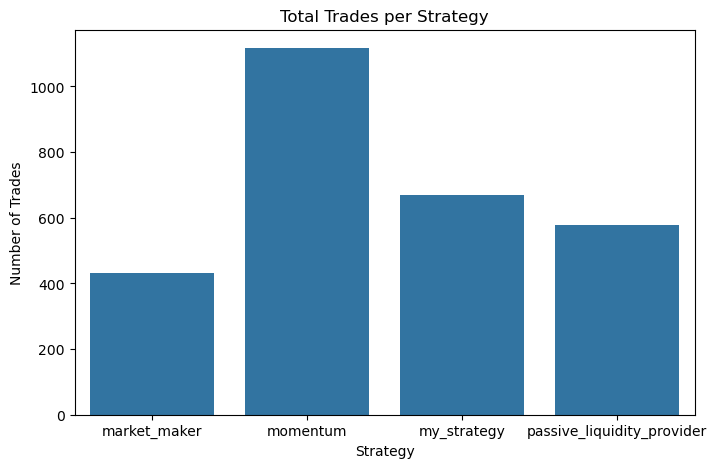

In [81]:
# 3. Total trades per strategy
trade_counts = df_trades.groupby('strategy').size().reset_index(name='num_trades')
plt.figure(figsize=(8,5))
sns.barplot(data=trade_counts, x='strategy', y='num_trades')
plt.title('Total Trades per Strategy')
plt.ylabel('Number of Trades')
plt.xlabel('Strategy')
plt.show()

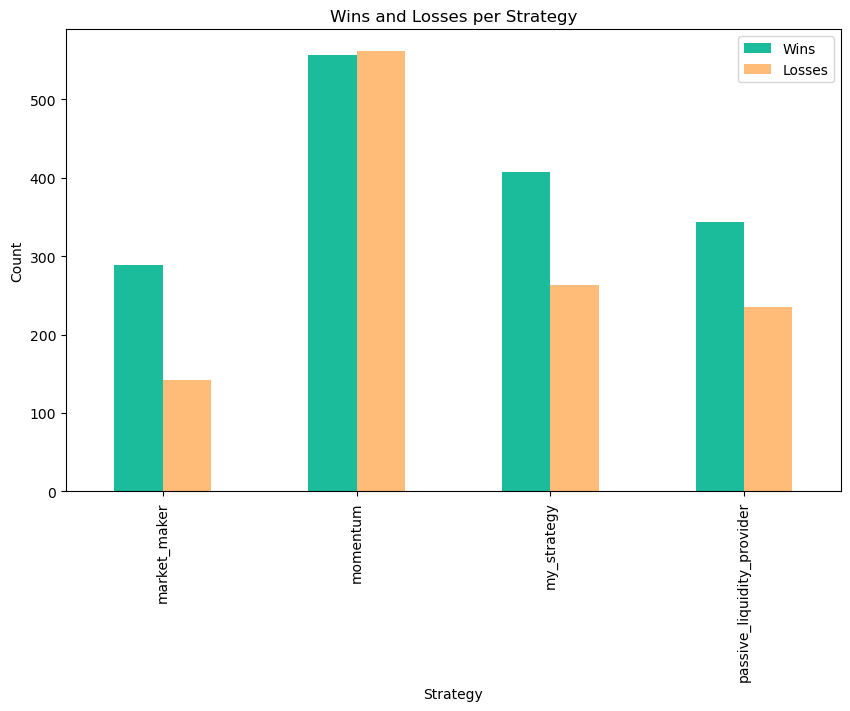

In [82]:
# 4. Wins and losses per strategy
winloss_counts = df_winloss.groupby(['strategy', 'type']).size().unstack(fill_value=0)
winloss_counts.plot(kind='bar', stacked=False, figsize=(10,6), color=['#1abc9c', '#ffbb78'])
plt.title('Wins and Losses per Strategy')
plt.ylabel('Count')
plt.xlabel('Strategy')
plt.legend(['Wins', 'Losses'])
plt.show()

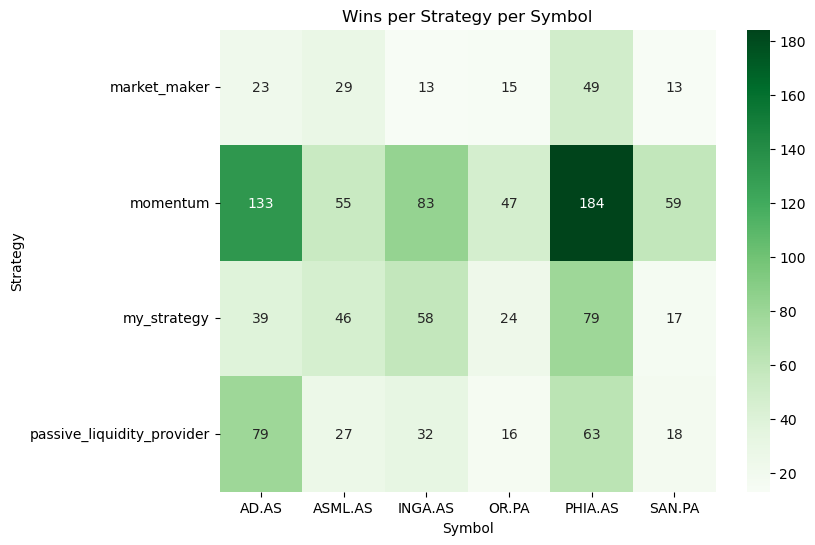

In [83]:
heatmap_data = df_winloss.pivot_table(index='strategy', columns='symbol', values='type', aggfunc=lambda x: (x=='WIN').sum())
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='Greens')
plt.title('Wins per Strategy per Symbol')
plt.ylabel('Strategy')
plt.xlabel('Symbol')
plt.show()

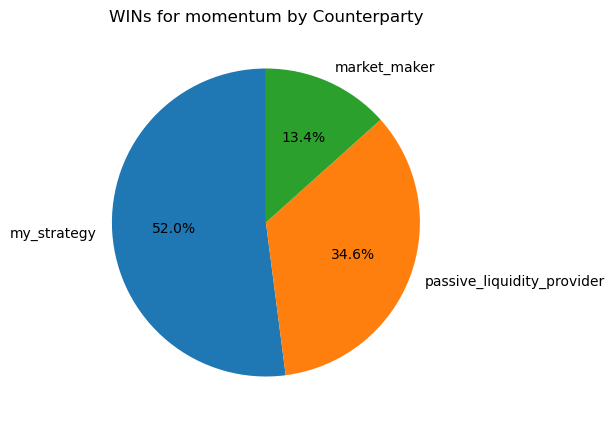

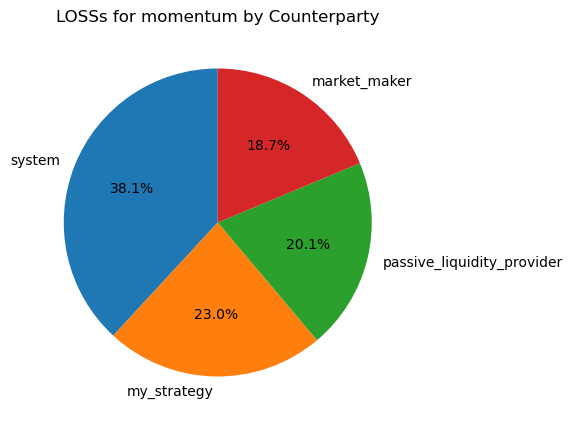

In [84]:
example_strat = 'momentum'
for ttype in ['WIN', 'LOSS']:
    counter_counts = df_winloss[(df_winloss['strategy']==example_strat) & (df_winloss['type']==ttype)]['counterparty'].value_counts()
    if not counter_counts.empty:
        plt.figure(figsize=(5,5))
        counter_counts.plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title(f'{ttype}s for {example_strat} by Counterparty')
        plt.ylabel('')
        plt.show()

In [85]:
table = pd.crosstab([df_winloss['strategy'], df_winloss['type']], df_winloss['counterparty'])
display(table)

counterparty                     market_maker  momentum  my_strategy  \
strategy                   type                                        
market_maker               LOSS             0        75           54   
                           WIN              0       104           30   
momentum                   LOSS           104         0          128   
                           WIN             75         0          292   
my_strategy                LOSS            30       292            0   
                           WIN             54       128            0   
passive_liquidity_provider LOSS             8       194           81   
                           WIN            109       112           14   

counterparty                     passive_liquidity_provider  system  
strategy                   type                                      
market_maker               LOSS                         109      51  
                           WIN                            8       0  
momentum                   LOSS                         112     212  
                           WIN                          194       0  
my_strategy                LOSS                          14      71  
                           WIN                           81       0  
passive_liquidity_provider LOSS                           0      61  
                           WIN                            0       0